# Detecting depression via tweets

## Content

*   [Introduction](#Introduction)
*   [Problem statement](#Problem-statement)
*   [Data collection](#Data-collection)
*   [Data cleaning](#Data-cleaning)
*   [EDA](#EDA)
*   [Modeling](#Modeling)
*   [Evaluation](#Evaluation)
*   [Modeling again](#Modeling-again)
*   [Evaluation for second model](#Evaluation-for-second-model)
*   [Conclusions and recommendations](#Conclusions-and-recommendations)

## Introduction

Based on World Health Organisation (WHO), depression is a common mental disorder. Globally, more than 264 million people of all ages suffer from depression. Depression is different from usual mood fluctuations and short-lived emotional responses to challenges in everyday life. Especially when long-lasting and with moderate or severe intensity, depression may become a serious health condition. It can cause the affected person to suffer greatly and function poorly at work, at school and in the family. At its worst, depression can lead to suicide. 

Depression is highly treatable. When depression is recognised and treated, a person’s quality of life can be greatly improved.



## Problem statement

We can leverage social media to detect depression. One good platform is Twitter as users can easily create an account by remaining anonymous since it doesn't require personal information. 

Users are able to express their thoughts freely without worrying about being judged on twitter . My objective is to detect signs of depression via tweets so we can encourage these individuals to seek help and treatment. 

Using data from other sources, I selected 3 classification models and LSTM + CNN model to train the data, and will select the best model based on accuracy for further evaluation. 

I will also look at if the model can still predict with good accuracy even after removing the top feature word.

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import shap
import spacy
import contractions

from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score

# for reproducibility
np.random.seed(42) 

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data collection

I use datasets from these two sources and did further cleaning manually to get the final set of depressed tweets.<br>


*   [Depression Detection with Boosting Ensemble Learning Classifiers](https://github.com/Harshita9511/Depression-Detection-with-Boosting-Ensemble-Learning-Classifiers)
*   [Detecting Depression in Tweets](https://github.com/viritaromero/Detecting-Depression-in-Tweets)
<br><br>

For positive tweets, I use a sample of 1250 tweets labeled positive from [Sentiment140 Kaggle dataset](https://www.kaggle.com/kazanova/sentiment140) 

After which, I combine both depressed and positive tweets which make up the final dataset.


In [4]:
tweets = pd.read_csv('data/sentiment data.csv')
tweets.head()

,tweet,label
0,Depression is really getting on my nerves. I am having difficult time dealing with it.. No one knows with what m going through. Its getting worse and worse day by day. Waiting for my death to come.,1
1,dealing with the debts of depression and trying to get back to being ok again,1
2,i have depression,1
3,True struggles: -being lonely and also anti-social -having no friends and also hating all people - wanting to do stuff and also trying to get over depression -wanting to eat healthy and also too broke to afford it -hates drinking and also drinks myself to sleep everyday рџ’Ђ,1
4,help me please. M dying with Depression.,1


In [5]:
# check the number of rows and columns
tweets.shape

(2506, 2)

In [6]:
# Depressed tweets are labeled as 1, whereas non-depresssed tweets are labeled as 0
tweets['label'].value_counts()

1    1256
0    1250
Name: label, dtype: int64

In [7]:
# instantiate SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# create a new column - vader_score to find out the sentiment score of the tweet. 
# positive sentiment: compound score >=0.5
# neutral sentiment: (compound score >-0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
tweets['vader_score'] = tweets['tweet'].apply(lambda x: analyser.polarity_scores(x)['compound'])

In [8]:
# create a new column - word_count for EDA purpose later
tweets['word_count'] = tweets['tweet'].apply(lambda x: len(x.split()))

In [9]:
tweets.head()

,tweet,label,vader_score,word_count
0,Depression is really getting on my nerves. I am having difficult time dealing with it.. No one knows with what m going through. Its getting worse and worse day by day. Waiting for my death to come.,1,-0.9578,37
1,dealing with the debts of depression and trying to get back to being ok again,1,-0.3612,15
2,i have depression,1,-0.5719,3
3,True struggles: -being lonely and also anti-social -having no friends and also hating all people - wanting to do stuff and also trying to get over depression -wanting to eat healthy and also too broke to afford it -hates drinking and also drinks myself to sleep everyday рџ’Ђ,1,-0.9294,48
4,help me please. M dying with Depression.,1,0.0772,7


## Data cleaning

I created a function here to clean the tweets as it contains punctuations, symbols, stopwords etc and the final step is to lemmatise to get the root word to reduce word duplicates.

In [10]:
def clean_text(tweet):

    # remove url 
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'www.+', '', tweet)
    tweet = re.sub(r'pic.+', '', tweet)
    
    # remove hashtags, @mention, emoji
    tweet = ' '.join(re.sub('(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)', ' ', tweet).split())
    
    # remove numbers
    tweet = re.sub(r'\d+', '', tweet) 
    
    # expand contraction words eg. I'd --> I would have
    expanded_words = []   
    for word in tweet.split():
        expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    
    #remove punctuation and symbols
    expanded_text = re.sub(r'[^A-Za-z0-9]', ' ', expanded_text)
    
    # convert to lowercase
    expanded_text = expanded_text.lower()
    
    # remove stopwords
    spacy_stopwords = STOP_WORDS
    spacy_stopwords |= {'lol', 'andquote', 'twitter', 'andamp'}
    
    words = expanded_text.split()
    
    full_text = ''
    for word in words:
        if word not in spacy_stopwords:
            full_text += word + ' '       

    nlp = spacy.load('en_core_web_sm')      
    full_text_nlp = nlp(full_text)      

    # lemmatise to get the root word        
    lemmatized_sentence = ' '

    for word in full_text_nlp:
        lemmatized_sentence += word.lemma_ + ' '

    return lemmatized_sentence

In [11]:
# applying the function to clean the text, this takes quite awhile
%%time
tweets['clean_tweet'] = tweets['tweet'].apply(clean_text)

CPU times: user 26min 28s, sys: 27.2 s, total: 26min 55s
Wall time: 26min 54s


In [12]:
# remove
tweets.shape

(2506, 5)

In [13]:
# drop duplicate rows
tweets.drop_duplicates(subset='clean_tweet', keep=False, inplace=True)

In [14]:
# check out what are the number of rows and columns now
tweets.shape

(2345, 5)

In [15]:
# check out how the clean data looks like
tweets.head(10)

,tweet,label,vader_score,word_count,clean_tweet
0,Depression is really getting on my nerves. I am having difficult time dealing with it.. No one knows with what m going through. Its getting worse and worse day by day. Waiting for my death to come.,1,-0.9578,37,depression get nerve have difficult time deal know m go get bad bad day day wait death come
1,dealing with the debts of depression and trying to get back to being ok again,1,-0.3612,15,deal debts depression try ok
3,True struggles: -being lonely and also anti-social -having no friends and also hating all people - wanting to do stuff and also trying to get over depression -wanting to eat healthy and also too broke to afford it -hates drinking and also drinks myself to sleep everyday рџ’Ђ,1,-0.9294,48,true struggle lonely anti social have friend hate people want stuff try depression want eat healthy broke afford hate drink drink sleep everyday
4,help me please. M dying with Depression.,1,0.0772,7,help m die depression
5,cant wait to go home and take a fat ass depression nap,1,-0.8020,12,wait home fat ass depression nap
6,fuckin petas got me stressed out. i also gotta deal with high induced depression all day.,1,-0.7269,16,fuckin petas get stress get deal high induce depression day
7,suffering from depression and anxiety. having suicidal thoughts. #MentalHealthBillKE,1,-0.9186,9,suffer depression anxiety have suicidal thought
8,My depression is horrible right now.,1,-0.8020,6,depression horrible right
10,ik heb fucking 13 a 14 hr sleep thats what depression does to me,1,-0.5719,14,ik heb fucking hr sleep depression
11,"A MOFO indeed. The ebb and flow, like the ocean waves hitting your feet as they come crashing in Redondo or Malibu. a daily struggle for me. Turns into depression & directly effects my life. Add other heartbreaks to the mix & it's a real bitch. Deep sigh.",1,-0.9341,48,mofo ebb flow like ocean wave hit foot come crash redondo malibu daily struggle turn depression directly effect life add heartbreak mix real bitch deep sigh


## EDA

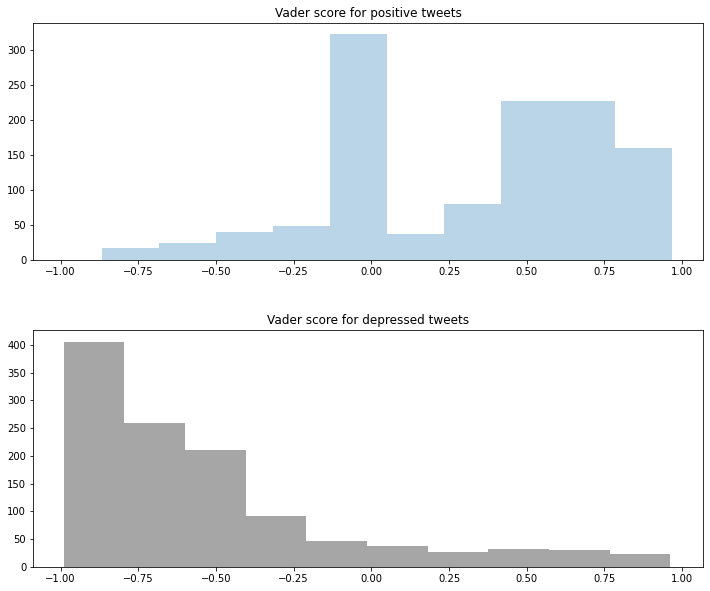

In [16]:
# plot histogram for vader score
fig, ax = plt.subplots(1, 2, figsize=(12,10))

ax1 = plt.subplot(2,1,1)
ax1.set_title('Vader score for positive tweets')
ax1.hist(tweets[tweets['label'] == 0]['vader_score'], alpha=0.3);

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.set_title('Vader score for depressed tweets')
ax2.hist(tweets[tweets['label'] == 1]['vader_score'], color=['grey'], alpha=0.7)

plt.subplots_adjust(hspace=0.3);

For positive tweets, majority of them lies between 0.25 and 1 but there's a spike around between -0.1 and 0, as they are neutral tweets so I'm not that concerned of. In general, the histogram tally with the notion of positive tweets.
<br>
For depressed tweets, majority of them lies between -0.5 to -1 but there are a small number of them that lies greater than 0.5. As it's a small proportion, I would not investigate further and use the current data to see how the results of the modeling will be like.

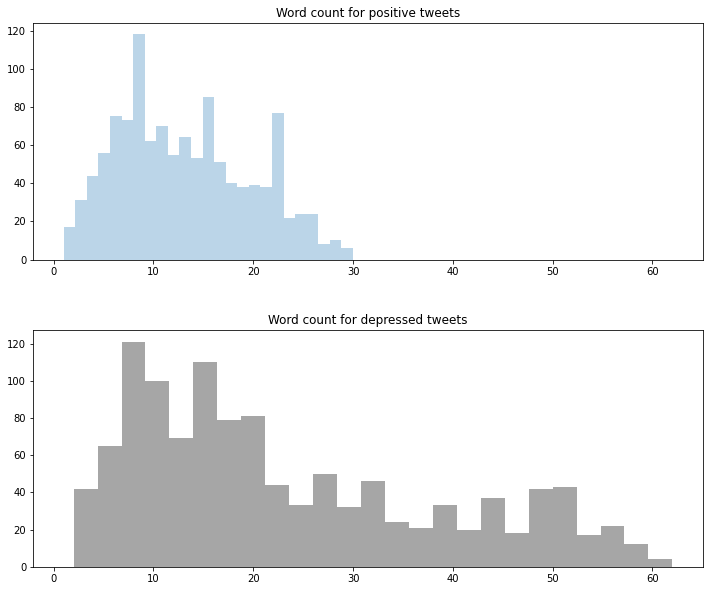

In [17]:
# plot histogram for word count
fig, ax = plt.subplots(2, 1, figsize=(12,10))

ax1 = plt.subplot(2,1,1)
ax1.set_title('Word count for positive tweets')
ax1.hist(tweets[tweets['label'] == 0]['word_count'], bins=25, alpha=0.3);

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.set_title('Word count for depressed tweets')
ax2.hist(tweets[tweets['label'] == 1]['word_count'], bins=25, color=['grey'], alpha=0.7)

plt.subplots_adjust(hspace=0.3);

Positive tweets has a word count of mostly 30 words or lesser whereas depressed tweets has a range of word counts with quite a large portion of it with less than 20 words.

In [18]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15, 15))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [19]:
positive_tweet = tweets[tweets['label'] ==0]
positive_text = " ".join(word for word in positive_tweet['clean_tweet'])

depressed_tweet = tweets[tweets['label'] ==1]
depressed_text = " ".join(word for word in depressed_tweet['clean_tweet'])

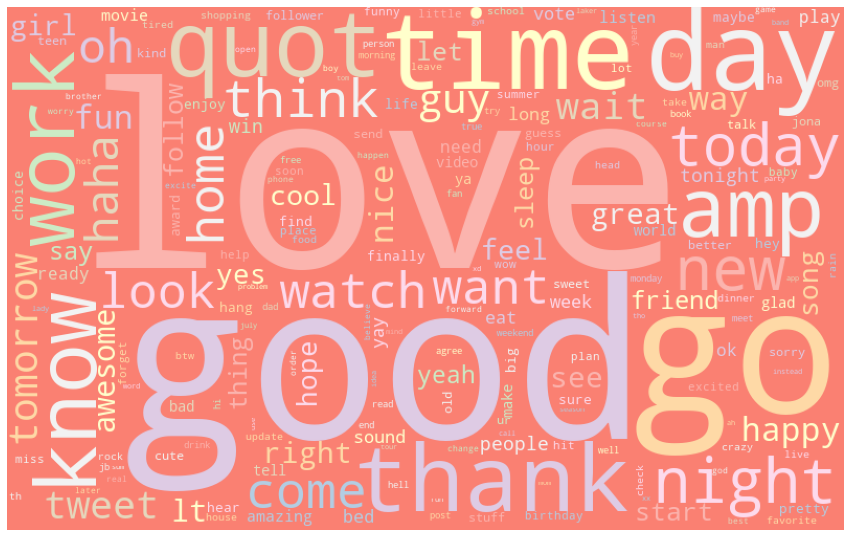

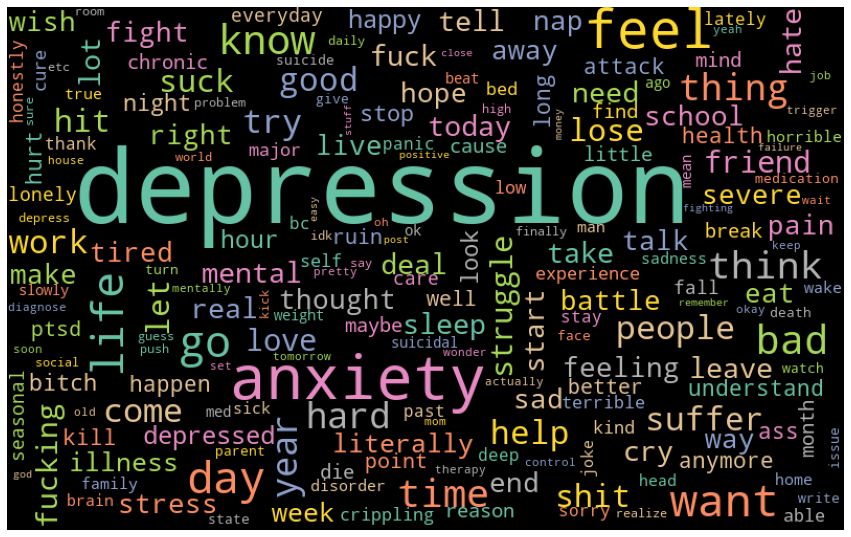

In [20]:
## exclude stopwords
# Generate word cloud
postive_wordcloud = WordCloud(width = 800, height = 500, random_state=1, background_color='salmon', 
                      colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(positive_text)

depressed_wordcloud = WordCloud(width = 800, height = 500, random_state=1, background_color='black', 
                      colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(depressed_text)
# Plot
plot_cloud(postive_wordcloud)
plot_cloud(depressed_wordcloud)

In [21]:
# create a function to vectorize the data

def vectorizer_df(df, vectorizer):

    # Instantiate CountVectorizer
    vec = vectorizer(ngram_range= (1, 2))

    # convert data to dataframe
    df_vec = pd.DataFrame(vec.fit_transform(df['clean_tweet']).todense(), 
                            columns=vec.get_feature_names())

    # Instantiate CountVectorizer, excluding stopwords again as there might be different results after 
    #lemmatizing in the previous function. And using ngram_range(1,2) to explore the data
    vec = vectorizer(stop_words = 'english', ngram_range= (1, 2))

    # convert data to dataframe
    df_vec_stopwords = pd.DataFrame(vec.fit_transform(df['clean_tweet']).todense(), 
                            columns=vec.get_feature_names())

    return df_vec, df_vec_stopwords

In [22]:
# input netflix dataframe into the function 
positive_cvec, positive_cvec_stopwords = vectorizer_df(positive_tweet, CountVectorizer)


# input amazon dataframe into the function 
depressed_cvec, depressed_cvec_stopwords = vectorizer_df(depressed_tweet, CountVectorizer)

In [23]:
# create a function to plot visualisation

def plot_vectorizer(df_vec, df_vec_stopwords, sub_reddit, vectorizer, xlabel, colour, alpha):

    # set figure size
    plt.figure(figsize = (20, 6))

    # plot top occuring words 
    plt.subplot(1, 2, 1)
    plt.title('Top 10 occuring words in ' + sub_reddit + ' via ' + vectorizer, size=14)
    plt.xlabel(xlabel, size=13)
    plt.tick_params(labelsize=12)
    df_vec.sum().sort_values().tail(10).plot(kind='barh', color=colour, alpha=alpha);

    # plot top occuring words without stopwords
    plt.subplot(1, 2, 2)
    plt.title('\nTop 10 occuring words in ' + sub_reddit +' (excluding stop words) via ' + vectorizer, size=14)
    plt.xlabel(xlabel, size=13)
    plt.tick_params(labelsize=12)
    df_vec_stopwords.sum().sort_values().tail(10).plot(kind='barh', color=colour, alpha=alpha);

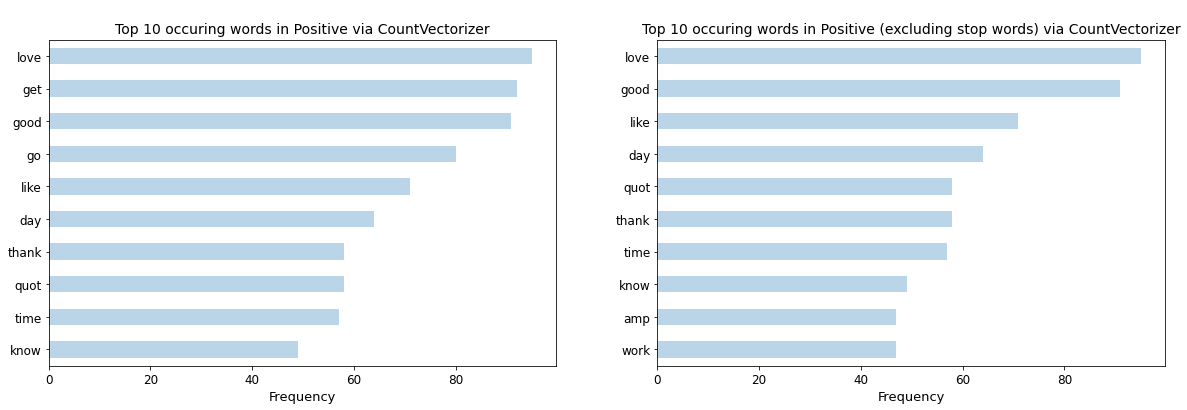

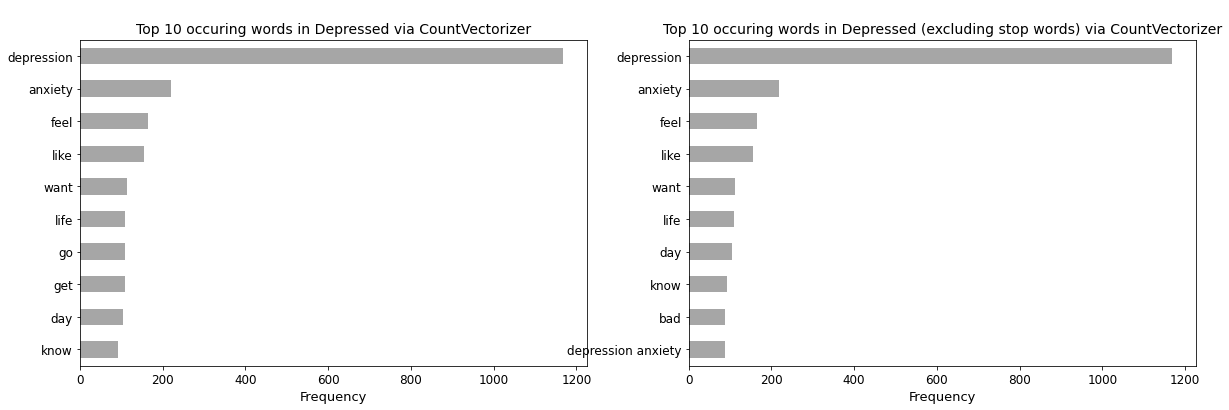

In [24]:
plot_vectorizer(positive_cvec, positive_cvec_stopwords, 'Positive', 'CountVectorizer', 'Frequency', 'C0', 0.3)
plot_vectorizer(depressed_cvec, depressed_cvec_stopwords, 'Depressed', 'CountVectorizer', 'Frequency', 'grey', 0.7)

In [25]:
positive_tvec, positive_tvec_stopwords = vectorizer_df(positive_tweet, TfidfVectorizer)
depressed_tvec, depressed_tvec_stopwords = vectorizer_df(depressed_tweet, TfidfVectorizer)

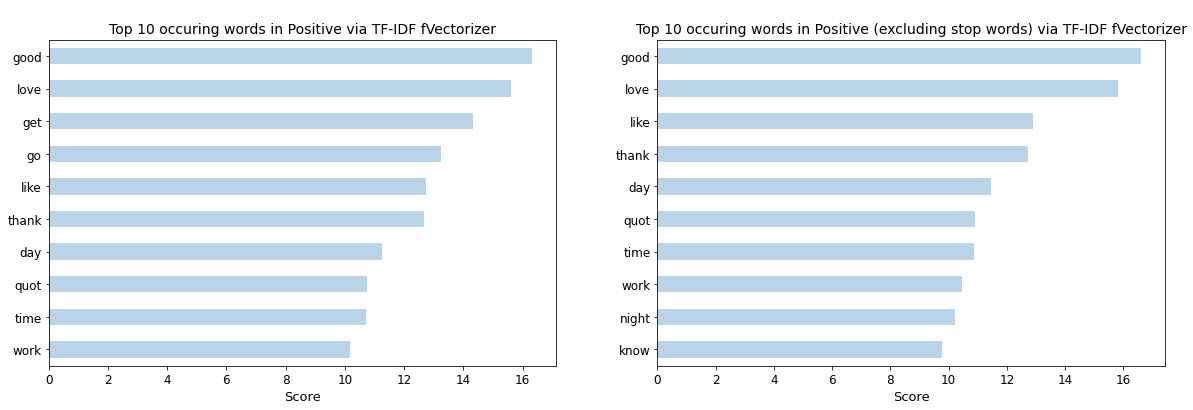

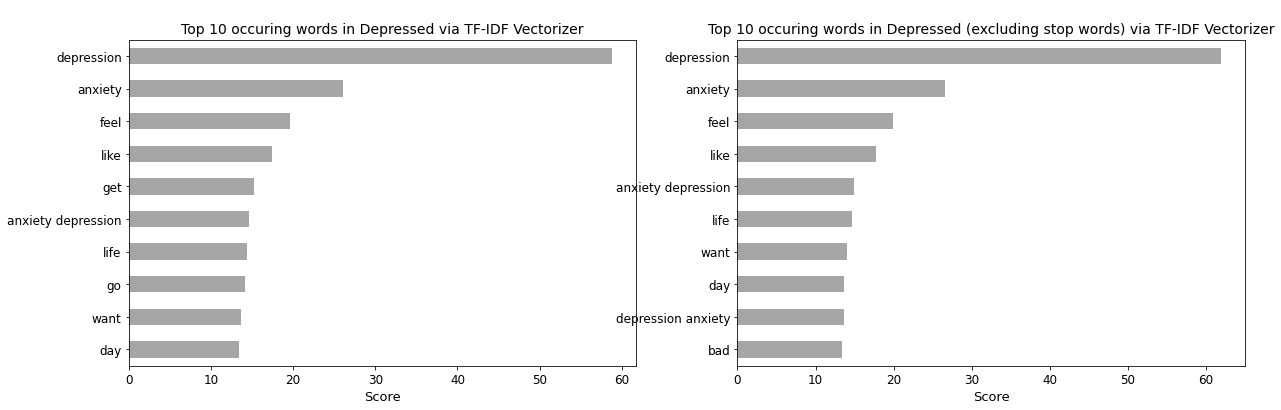

In [26]:
plot_vectorizer(positive_tvec, positive_tvec_stopwords, 'Positive', 'TF-IDF fVectorizer', 'Score', 'C0', 0.3)
plot_vectorizer(depressed_tvec, depressed_tvec_stopwords, 'Depressed', 'TF-IDF Vectorizer', 'Score', 'grey', 0.7)

In positive tweets, 'good' and 'love' are the top words for both CountVectorizer and TF-IDF vectorizer.<br>
In depressed tweets, 'depression' has very high frequency and score for CountVectorizer and TF-IDF Vectorizer respectively.

## Modeling

### Create X and y for modeling

In [27]:
# create X and y variables
X = tweets['clean_tweet']
y = tweets['label']

### Baseline score

In [28]:
y.value_counts(normalize = True)

0    0.503198
1    0.496802
Name: label, dtype: float64

With a baseline score of 50%, it means that if i predict a tweet to be positive or depressed, it will have a 50:50 chance each.

### Train-test-split

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Logistic regression

In [30]:
pipe_lr = Pipeline([('vec', None), ('model', LogisticRegression())])
param_grid_lr = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                'model__max_iter': [3000, 4000],
                'model__penalty': ['l1', 'l2'],
                'model__solver': ['saga'],
                'model__C': [1.0, 5.0],
                'model__random_state': [42],
                'vec__stop_words': ['english'], 
                'vec__max_features': [2000, 2500], 
                'vec__min_df': [2, 5], 
                'vec__max_df': [0.90, 0.95],
                'vec__ngram_range': [(1, 1), (1, 2)]}
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy')
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec', None),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state

### Multinomial Naive Bayes

In [31]:
pipe_nb = Pipeline([('vec', None), ('model', MultinomialNB())])
param_grid_nb = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                 'model__alpha':[0.75, 0.8, 0.85],
                 'model__fit_prior':[True],
              'vec__stop_words': ['english'],
              'vec__max_features': [1500, 2000],
              'vec__min_df': [3, 10],
              'vec__max_df': [0.90, 0.99],
              'vec__ngram_range': [(1, 1), (1, 3)]}
gs_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='accuracy')
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec', None),
                                       ('model',
                                        MultinomialNB(alpha=1.0,
                                                      class_prior=None,
                                                      fit_prior=True))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'model__alpha': [0.75, 0.8, 0.85],
                         'model__fit_prior': [True],
                         'vec': [CountVectorizer(analyzer='word', binary=False,
                                                 decode_error='strict',
                                                 dtype=<cla...
                                                 stop_words=None,
                                                 strip_accents=None,
                                                 su

### Random Forest

In [32]:
# check the best params for RandomForestClassifier
pipe_rf = Pipeline([('vec', None), ('model', RandomForestClassifier())])
param_grid_rf = {'vec': [CountVectorizer(), TfidfVectorizer()], 
              'model__n_estimators': [50, 100],
              'model__max_depth': [6, 10, 16],
              'model__min_samples_leaf': [6, 10],
              'model__min_samples_split': [16, 32],
              'model__random_state': [42],
              'vec__stop_words': ['english'],
              'vec__max_features': [1500, 2000],
              'vec__min_df': [10, 20], 
              'vec__max_df': [0.8, 0.9],
              'vec__ngram_range': [(1, 1), (1, 2)]}
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy')
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec', None),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_sp

### LSTM + CNN

In [33]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [34]:
# use Tokenizer to update internal vocab using X_train
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [35]:
# check the number of unique words
word_index = tokenizer.word_index
len(word_index)

# add 1 to word_index to store the dimensions for the words for which no pretrained word embeddings exist
vocab_size = len(tokenizer.word_index) + 1

In [36]:
#Transforms each word to a sequence of integers
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [37]:
# pad documents to a max length of 100 words
maxlen = 60

# set dimension of each word
embedding_dim = 50

X_train_pad = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

In [38]:
model = Sequential()

# Embedded layer
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(Dropout(0.5))

# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [39]:
#Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.0004)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 50)            164650    
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            8032      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

Training Accuracy: 0.9994
Testing Accuracy:  0.9819


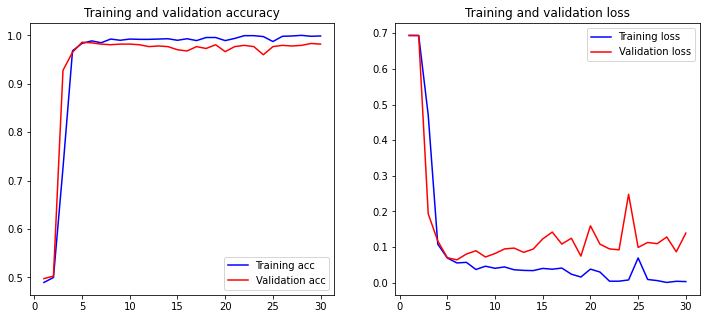

In [40]:
history = model.fit(X_train_pad, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=8)
nn_train_loss, nn_train_accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(nn_train_accuracy))
nn_test_loss, nn_test_accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(nn_test_accuracy))
plot_history(history)

## Evaluation

In [41]:
# evaluate the train and test score for all models
print(' Logistic Regression '.center(28, "="))
print(f'Train score: {gs_lr.score(X_train, y_train):.4f}')
print(f'Test score: {gs_lr.score(X_test, y_test):.4f}')
print()
print(' Multinomial Naive Bayes '.center(31, "="))
print(f'Train score: {gs_nb.score(X_train, y_train):.4f}')
print(f'Test score: {gs_nb.score(X_test, y_test):.4f}')
print()
print(' Random Forest '.center(21, "="))
print(f'Train score: {gs_rf.score(X_train, y_train):.4f}')
print(f'Test score: {gs_rf.score(X_test, y_test):.4f}')
print()
print(' LSTM + CNN '.center(18, "="))
print(f'Train score: {nn_train_accuracy:.4f}')
print(f'Test score: {nn_test_accuracy:.4f}')

=== Logistic Regression ====
Train score: 0.9822
Test score: 0.9793

=== Multinomial Naive Bayes ===
Train score: 0.9554
Test score: 0.9470

=== Random Forest ===
Train score: 0.9822
Test score: 0.9793

=== LSTM + CNN ===
Train score: 0.9994
Test score: 0.9819


Logistic Regression and Random Forest both have very good score with minimal overfitting. For LSTM + CNN model, though the train score is high 0.99, the test score is at 0.96 which indicating there's some overfitting, and the training and validation loss isn't ideal as well.
<br>
Since Logistic Regression and Random Forest have similar scores I will take a look at the confusion matrix to evaluate further which is a better model.

### Confusion matrix

In [42]:
# create a function for confusion matrix and its repective values
def confusion_mat(model, title):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format = 'd', 
                          display_labels=['Positive', 'Depressed\n'])
    plt.title(title + '\n', size=14) ;
    print(f'True Positive: {tp}')
    print(f'True Negative: {tn}')
    print(f'False Positive: {fp}')
    print(f'False Negative: {fn}')
    print()
    print(f'Accuracy: {accuracy_score(y_test, preds):.3f}')
    print(f'Sensitivity(recall): {recall_score(y_test, preds):.3f}')
    print(f'Specificity: {(tn/(tn+fp)):.3f}')
    print(f'Precision: {precision_score(y_test, preds):.3f}')
    print()

True Positive: 371
True Negative: 387
False Positive: 2
False Negative: 14

Accuracy: 0.979
Sensitivity(recall): 0.964
Specificity: 0.995
Precision: 0.995



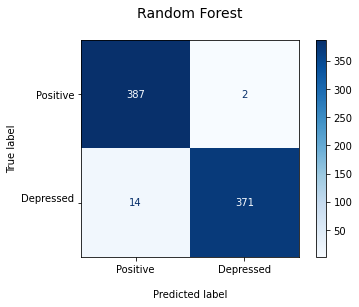

In [43]:
confusion_mat(gs_rf, 'Random Forest')

True Positive: 369
True Negative: 389
False Positive: 0
False Negative: 16

Accuracy: 0.979
Sensitivity(recall): 0.958
Specificity: 1.000
Precision: 1.000



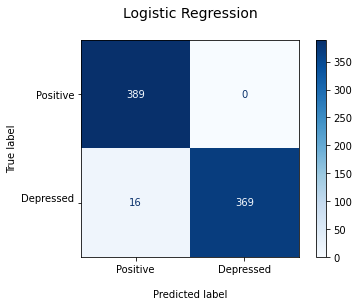

In [44]:
confusion_mat(gs_lr, 'Logistic Regression')

Both Logistic Regression and Random Forest have very good specificity and precision score at 0.995 and 1.0 respectively. Since I want to detect tweets that are depressed, I would want to minimise false negatives (predicted Positive but is actually Depressed). <br>
Random Forest has a slightly lower false negatives at 14, therefore I will choose Random Forest as my final model.

### SHAP

In [45]:
# Explanation of SHAP: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
# Use SHAP to see the positive and negative relationshop of the predictors with the target variable 

classifier = gs_rf.best_estimator_['model']

shap.initjs()

X_train_shapped = gs_rf.best_estimator_['vec'].fit_transform(X_train)
X_train_shapped = X_train_shapped.astype(dtype='float')

In [46]:
# sampling data from the training set to reduce time taken as KernelExplainer requires a long running time for large samples
X_train_sample = shap.sample(X_train_shapped, 200)

# creating the KernelExplainer using the classifier and training sample
SHAP_explainer = shap.KernelExplainer(classifier.predict, X_train_sample)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [47]:
# calculating the shap values of the train sample using the explainer 
shap_vals_train = SHAP_explainer.shap_values(X_train_sample)

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
# converting the train samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations to include feature value
colour_train = pd.DataFrame(X_train_sample.todense())

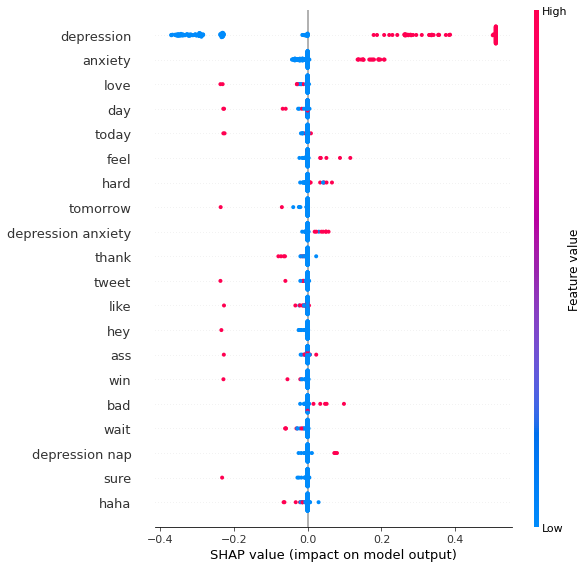

In [49]:
# plot the summary plot for train data sample
shap.summary_plot(shap_vals_train, colour_train, feature_names = gs_rf.best_estimator_['vec'].get_feature_names())

The summary plot displays the positive and negative relationship of the word with the target variable - label, and the following information: <br>

*   Feature importance: Variables are ranked in descending order. The most important feature is 'depression' followed by 'anxiety'.
*   Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
*   Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
*   Correlation: For 'depression', it has a high and positive impact on Depressed tweet as depicted by the red dots on the right side of x-axis. Whereas for word such as 'love', it has a medium and negative impact as the value is -0.2 and it's on the left side of x-axis.

## Remove 'depression' from tweet

Since depression is a top feature in determining whether it's a Depressed tweet, I will remove this word from the dataset and see if the model can still do well.

In [50]:
# create a copy of the original data
tweets_copy = tweets.copy()

# remove 'depression' word
tweets_copy['clean_tweet_revised'] = tweets_copy['clean_tweet']
tweets_copy['clean_tweet_revised'] = tweets_copy['clean_tweet_revised'].replace(['depression'], '', regex=True)

In [51]:
# check data
tweets_copy.head()

,tweet,label,vader_score,word_count,clean_tweet,clean_tweet_revised
0,Depression is really getting on my nerves. I am having difficult time dealing with it.. No one knows with what m going through. Its getting worse and worse day by day. Waiting for my death to come.,1,-0.9578,37,depression get nerve have difficult time deal know m go get bad bad day day wait death come,get nerve have difficult time deal know m go get bad bad day day wait death come
1,dealing with the debts of depression and trying to get back to being ok again,1,-0.3612,15,deal debts depression try ok,deal debts try ok
3,True struggles: -being lonely and also anti-social -having no friends and also hating all people - wanting to do stuff and also trying to get over depression -wanting to eat healthy and also too broke to afford it -hates drinking and also drinks myself to sleep everyday рџ’Ђ,1,-0.9294,48,true struggle lonely anti social have friend hate people want stuff try depression want eat healthy broke afford hate drink drink sleep everyday,true struggle lonely anti social have friend hate people want stuff try want eat healthy broke afford hate drink drink sleep everyday
4,help me please. M dying with Depression.,1,0.0772,7,help m die depression,help m die
5,cant wait to go home and take a fat ass depression nap,1,-0.8020,12,wait home fat ass depression nap,wait home fat ass nap


## Modeling again

In [52]:
# create X and y variables
X = tweets_copy['clean_tweet_revised']
y = tweets_copy['label']

### Train-test-split

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Random forest

In [54]:
# check the best params for RandomForestClassifier
pipe_rf_1 = Pipeline([('vec', None), ('model', RandomForestClassifier())])
param_grid_rf_1 = {'vec': [CountVectorizer(), TfidfVectorizer()], 
              'model__n_estimators': [50, 100],
              'model__max_depth': [6, 10, 16],
              'model__min_samples_leaf': [6, 10],
              'model__min_samples_split': [16, 32],
              'model__random_state': [42],
              'vec__stop_words': ['english'],
              'vec__max_features': [1500, 2000],
              'vec__min_df': [10, 20], 
              'vec__max_df': [0.8, 0.9],
              'vec__ngram_range': [(1, 1), (1, 2)]}
gs_rf_1 = GridSearchCV(pipe_rf_1, param_grid_rf_1, cv=5, scoring='accuracy')
gs_rf_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec', None),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_sp

## Evaluation for second model

In [55]:
# evaluate the train and test score 
print(' Random Forest (initial model) '.center(21, "="))
print(f'Train score: {gs_rf.score(X_train, y_train):.4f}')
print(f'Test score: {gs_rf.score(X_test, y_test):.4f}')
print()
print(' Random forest (second model) '.center(21, "="))
print(f'Train score: {gs_rf_1.score(X_train, y_train):.4f}')
print(f'Test score: {gs_rf_1.score(X_test, y_test):.4f}')
print()

 Random Forest (initial model) 
Train score: 0.6378
Test score: 0.6305

 Random forest (second model) 
Train score: 0.8014
Test score: 0.7778



Removing the word 'depression' has seen a drop in the accuracy by approximately 20%. Perhaps it would be good to look at alternative way to improve accuracy without having the word 'depression' to make the model more robust.

## Conclusions and recommendations

In conclusion, based on the initial modeling results, Random Forest is the best model that can detect tweets with signs of depression as it has a high 98% accuracy score and low false negatives as well. It would be good to look into what is the data that causes the false negatives so I can improve the model further and lower false negatives. 

After removing the word 'depression', accuracy dropped by 20% which means that if there are depressed tweets that does not contain this keyword, the model might not be able to label correctly. I would consider to look at how to improve the model when top keywords are not present so that the model can still work well.

I would also consider to explore LSTM + CNN further by using pretained word embedding such as GloVe and see if results can be better.

As depression is only one of the types of mental health disorder, I would also consider to look at other common mental health disorder such as anxiety as well.<br>
<br>
At a global level, I would recommend Twitter to consider having such model to monitor tweets worldwide and reach out to local organisations if they find any tweets that are of concern. 

Local organisations such as Institute of Mental Health (IMH) Samaritans of Singapore (SOS), Singapore Association for Mental Health (SAMH) or even goverment organisation - Health Promotion Board can also consider looking at using the model to monitor tweets that are of red flags and render help to individuals if required.



